In [1]:
import pandas as pd
import numpy as np
import random

from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.metrics import precision_score, recall_score, f1_score, confusion_matrix

import torch
from torch.utils.data import Dataset, DataLoader
import torch.nn as nn
import torch.optim as optim

import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [3]:
# Parámetros del dataset sintético
n_samples = 1000000
n_features = 50
categorical_columns = [f'Cat{i}' for i in range(5)]
continuous_columns = [f'Cont{i}' for i in range(n_features - len(categorical_columns))]

# Generación de datos sintéticos
np.random.seed(42)
categorical_data = np.random.randint(0, 5, size=(n_samples, len(categorical_columns)))

# Generar datos aleatorios centrados en 0 para fluctuación
dataCont = np.random.randn(n_samples, len(continuous_columns))

# Crear un array para almacenar los resultados con fluctuación controlada
continuous_data = np.zeros_like(dataCont)

for i in range(n_samples):
    # Calcular el rango de la ventana móvil
    start = max(0, i - 10 + 1)
    # Calcular la media acumulada dentro de la ventana
    window_mean = np.mean(dataCont[start:i+1], axis=0)
    # Añadir el valor medio en lugar de la suma acumulada
    continuous_data[i] = window_mean

# Generación de etiquetas basadas en una función no lineal de las características
labels = pd.Series(np.zeros(n_samples))
for i in range(n_samples):
    #suma las continuous data pares y resta los impares
    linear_combination = 0
    for j in range(len(continuous_columns)):
        if j % 2 == 0:
            linear_combination += continuous_data[i, j]
        else:
            linear_combination -= continuous_data[i, j]
    
    if linear_combination > 0:
        labels[i] = 1

# Crear DataFrame sintético
data = pd.DataFrame(np.hstack([categorical_data, continuous_data]), columns=categorical_columns + continuous_columns)
data['Normal/Attack'] = labels
data['Index'] = data.index
data = data.drop(columns=['Normal/Attack'])

print(data.head())

   Cat0  Cat1  Cat2  Cat3  Cat4     Cont0     Cont1     Cont2     Cont3  \
0   3.0   4.0   2.0   4.0   4.0 -0.957101  2.132025 -0.022485  0.196817   
1   1.0   2.0   2.0   2.0   4.0 -0.659485  0.945424  0.311124 -0.319464   
2   3.0   2.0   4.0   1.0   3.0 -0.727712  0.791778  0.400998  0.054205   
3   1.0   3.0   4.0   0.0   3.0 -0.399707  0.330674  0.359399 -0.017317   
4   1.0   4.0   3.0   0.0   0.0 -0.330129  0.038273  0.513128 -0.056547   

      Cont4  ...    Cont36    Cont37    Cont38    Cont39    Cont40    Cont41  \
0 -0.369941  ... -1.281833  0.806634  2.274777  1.749662  0.864658  0.242672   
1 -0.296593  ... -0.537177  0.970400  0.822984  1.167994  0.461893  0.862418   
2 -0.372561  ... -0.173162  1.283624  0.005477  0.459446  0.058502  0.580938   
3 -0.567887  ... -0.706979  0.960979 -0.062699  0.333442  0.456124  0.172937   
4 -0.367455  ... -0.668643  0.784446 -0.152951  0.207724  0.205044  0.107519   

     Cont42    Cont43    Cont44  Index  
0  0.579799  0.281413  1.71

In [4]:
# porcentaje de anomalías y trafico normal
anomaly_percentage = labels.value_counts(normalize=True)[1]
normal_percentage = labels.value_counts(normalize=True)[0]
print(f"Anomaly percentage: {anomaly_percentage:.2%}")
print(f"Normal percentage: {normal_percentage:.2%}")

Anomaly percentage: 49.99%
Normal percentage: 50.01%


In [5]:
#busca una racha de 80 anomalías seguidas de 20 normales
def find_anomaly_streak(data, labels, anomaly_label=1, streak_length=80, normal_length=20):
    streaks = []
    current_streak = 0
    for i in range(len(data)):
        if labels[i] == anomaly_label:
            current_streak += 1
        else:
            if current_streak >= streak_length:
                streaks.append((i - current_streak, i))
            current_streak = 0
    if current_streak >= streak_length:
        streaks.append((len(data) - current_streak, len(data)))
    return streaks

find_anomaly_streak(data, labels, anomaly_label=1, streak_length=80, normal_length=20)

[(422936, 423022), (746186, 746268), (895610, 895696)]

In [6]:
segment_size = 500
padding_size = 50
train_percentage = 0.7
val_percentage = 0.15
test_percentage = 0.15

In [7]:
train_data_list, val_data_list, test_data_list, padding_data_list = [], [], [], []
train_labels_list, val_labels_list, test_labels_list, padding_labels_list = [], [], [], []
train_indexes_list, val_indexes_list, test_indexes_list, padding_indexes_list = [], [], [], []

for i in range(0, len(data), segment_size):

    init = i
    end = min(i + segment_size, len(data))

    segment_indexes = data['Index'].iloc[init:end]
    
    segment_data = data.iloc[init:end]
    segment_labels = labels.iloc[init:end]
    
    train_split_index = int(train_percentage * len(segment_data))
    val_split_index = int((train_percentage + val_percentage) * len(segment_data))
    
    #TRAIN
    train_data_list.append(segment_data.iloc[:train_split_index])
    train_labels_list.append(segment_labels.iloc[:train_split_index])
    
    # Padding before VALIDATION
    padding_start = max(0, train_split_index - padding_size)
    padding_data_list.append(segment_data.iloc[padding_start:train_split_index])
    padding_labels_list.append(segment_labels.iloc[padding_start:train_split_index])
    
    # VALIDATION
    val_data_list.append(segment_data.iloc[train_split_index:val_split_index])
    val_labels_list.append(segment_labels.iloc[train_split_index:val_split_index])
    
    # Padding before TEST
    padding_start_val = max(0, val_split_index - padding_size)
    padding_end_val = min(len(segment_data), val_split_index + padding_size)
    padding_data_list.append(segment_data.iloc[padding_start_val:val_split_index])
    padding_labels_list.append(segment_labels.iloc[padding_start_val:val_split_index])
    
    # TEST
    test_data_list.append(segment_data.iloc[val_split_index:])
    test_labels_list.append(segment_labels.iloc[val_split_index:])
    
    # Padding before next SEGMENT
    padding_end = min(len(segment_data), val_split_index + padding_size)
    padding_data_list.append(segment_data.iloc[val_split_index:padding_end])
    padding_labels_list.append(segment_labels.iloc[val_split_index:padding_end])

    train_indexes_list.append(segment_indexes.iloc[:train_split_index])
    val_indexes_list.append(segment_indexes.iloc[train_split_index:val_split_index])
    test_indexes_list.append(segment_indexes.iloc[val_split_index:])


# Concatenate
train_data = pd.concat(train_data_list).reset_index(drop=True)
val_data = pd.concat(val_data_list).reset_index(drop=True)
test_data = pd.concat(test_data_list).reset_index(drop=True)
padding_data = pd.concat(padding_data_list).reset_index(drop=True)

train_labels = pd.concat(train_labels_list).reset_index(drop=True)
val_labels = pd.concat(val_labels_list).reset_index(drop=True)
test_labels = pd.concat(test_labels_list).reset_index(drop=True)
padding_labels = pd.concat(padding_labels_list).reset_index(drop=True)

train_indexes = pd.concat(train_indexes_list).reset_index(drop=True)
val_indexes = pd.concat(val_indexes_list).reset_index(drop=True)
test_indexes = pd.concat(test_indexes_list).reset_index(drop=True)


print(f'Train data shape: {train_data.shape}')
print(f'Train labels shape: {train_labels.shape}')
print(f'Train index shape: {train_indexes.shape}')
print()

print(f'Validation data shape: {val_data.shape}')
print(f'Validation labels shape: {val_labels.shape}')
print(f'Validation index shape: {val_indexes.shape}')
print()

print(f'Test data shape: {test_data.shape}')
print(f'Test labels shape: {test_labels.shape}')
print(f'Test index shape: {test_indexes.shape}')
print()

x_train = train_data.to_numpy()
y_train = train_labels.to_numpy()
x_val = val_data.to_numpy()
y_val = val_labels.to_numpy()
x_test = test_data.to_numpy()
y_test = test_labels.to_numpy()

Train data shape: (700000, 51)
Train labels shape: (700000,)
Train index shape: (700000,)

Validation data shape: (150000, 51)
Validation labels shape: (150000,)
Validation index shape: (150000,)

Test data shape: (150000, 51)
Test labels shape: (150000,)
Test index shape: (150000,)



In [8]:
class TimeSeriesDataset(Dataset):
    def __init__(self, data, labels, indexes, stride=1, window_size=10):

        self.x = data.to_numpy(dtype=np.float32)  
        self.labels = labels.to_numpy(dtype=np.float32)  
        self.labels = np.array([[1, 0] if label == 0 else [0, 1] for label in self.labels], dtype=np.float32)
        self.indexes = indexes.to_numpy(dtype=np.int32)  
        self.window_size = window_size
        self.stride = stride

        self.valid_idxs = self._preprocess_windows()
        self.n_idxs = len(self.valid_idxs)

    def __len__(self):
        return self.n_idxs

    def __getitem__(self, idx):
        i = self.valid_idxs[idx]
        item = {}
        item["given"] = torch.from_numpy(self.x[i:i + self.window_size]).to(torch.float32)
        item["label"] = torch.tensor(self.labels[i + self.window_size - 1], dtype=torch.float32).to(device)
        item["answer"] = torch.tensor(self.labels[i + self.window_size-1], dtype=torch.float32).to(device)
        item["indexes"] = self.indexes[i + self.window_size - 1]
        return item

    def _preprocess_windows(self):
        temp_valid_idxs = []
        total_windows = len(self.x) - self.window_size + 1
        print(f"Total windows: {total_windows}")
        
        for L in range(0, total_windows, self.stride):
            window_indices = self.indexes[L:L + self.window_size]
            
            if np.all(np.diff(window_indices) == 1):
                temp_valid_idxs.append(L)
        
        print(f"Valid windows: {len(temp_valid_idxs)}")
        return np.array(temp_valid_idxs, dtype=np.int32)

In [9]:
zero_variance_columns = train_data.columns[train_data.nunique() <= 1].tolist()

train_data_trans = train_data.drop(columns=['Index'])
val_data_trans = val_data.drop(columns=['Index'])
test_data_trans = test_data.drop(columns=['Index'])

train_data_trans = train_data_trans.drop(columns=zero_variance_columns)
val_data_trans = val_data_trans.drop(columns=zero_variance_columns)
test_data_trans = test_data_trans.drop(columns=zero_variance_columns)

categorical_columns = [col for col in train_data_trans.columns if train_data_trans[col].nunique() < 10]
continuous_columns = [col for col in train_data_trans.columns if col not in categorical_columns]

print(f"Zero variance columns: {len(zero_variance_columns)}: {zero_variance_columns}")
print(f'Categorical columns: {len(categorical_columns)}: {categorical_columns}')
print(f'Continuous columns: {len(continuous_columns)}: {continuous_columns}')

Zero variance columns: 0: []
Categorical columns: 5: ['Cat0', 'Cat1', 'Cat2', 'Cat3', 'Cat4']
Continuous columns: 45: ['Cont0', 'Cont1', 'Cont2', 'Cont3', 'Cont4', 'Cont5', 'Cont6', 'Cont7', 'Cont8', 'Cont9', 'Cont10', 'Cont11', 'Cont12', 'Cont13', 'Cont14', 'Cont15', 'Cont16', 'Cont17', 'Cont18', 'Cont19', 'Cont20', 'Cont21', 'Cont22', 'Cont23', 'Cont24', 'Cont25', 'Cont26', 'Cont27', 'Cont28', 'Cont29', 'Cont30', 'Cont31', 'Cont32', 'Cont33', 'Cont34', 'Cont35', 'Cont36', 'Cont37', 'Cont38', 'Cont39', 'Cont40', 'Cont41', 'Cont42', 'Cont43', 'Cont44']


In [10]:
for col in categorical_columns:
    train_data_trans[col] = train_data_trans[col].astype('category')
    val_data_trans[col] = val_data_trans[col].astype('category')
    test_data_trans[col] = test_data_trans[col].astype('category')

In [11]:
#Standardize continuous columns and one-hot encode categorical columns
preprocessor = ColumnTransformer(
    transformers=[
        ("num", StandardScaler(), continuous_columns),
        ("cat", OneHotEncoder(handle_unknown="ignore", sparse_output=False), categorical_columns)
    ]
)

pipeline = Pipeline(steps=[("preprocessor", preprocessor)])

pipeline.fit(train_data_trans)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num', StandardScaler(),
                                                  ['Cont0', 'Cont1', 'Cont2',
                                                   'Cont3', 'Cont4', 'Cont5',
                                                   'Cont6', 'Cont7', 'Cont8',
                                                   'Cont9', 'Cont10', 'Cont11',
                                                   'Cont12', 'Cont13', 'Cont14',
                                                   'Cont15', 'Cont16', 'Cont17',
                                                   'Cont18', 'Cont19', 'Cont20',
                                                   'Cont21', 'Cont22', 'Cont23',
                                                   'Cont24', 'Cont25', 'Cont26',
                                                   'Cont27', 'Cont28', 'Cont29', ...]),
                                                 ('cat',
                                                  OneHotEncoder(handle_unknown='ignore',
                                                                sparse_output=False),
                                                  ['Cat0', 'Cat1', 'Cat2',
                                                   'Cat3', 'Cat4'])]))])

In [12]:
x_train_trans = pipeline.transform(train_data_trans)
x_val_trans = pipeline.transform(val_data_trans)
x_test_trans = pipeline.transform(test_data_trans)

In [13]:
categorical_feature_names = pipeline.named_steps["preprocessor"].transformers_[1][1].get_feature_names_out(categorical_columns)
all_feature_names = continuous_columns + list(categorical_feature_names)

x_train_df = pd.DataFrame(x_train_trans, columns=all_feature_names)
x_val_df = pd.DataFrame(x_val_trans, columns=all_feature_names)
x_test_df = pd.DataFrame(x_test_trans, columns=all_feature_names)

x_train_df.head()

,Cont0,Cont1,Cont2,Cont3,Cont4,Cont5,Cont6,Cont7,Cont8,Cont9,...,Cat3_0.0,Cat3_1.0,Cat3_2.0,Cat3_3.0,Cat3_4.0,Cat4_0.0,Cat4_1.0,Cat4_2.0,Cat4_3.0,Cat4_4.0
0,-3.011999,6.730460,-0.068881,0.617030,-1.175295,0.805706,-0.068492,1.510140,-3.322380,-0.902616,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0
1,-2.073737,2.983352,0.986634,-1.019259,-0.943034,-2.370282,-2.956515,3.614063,-0.505696,0.382199,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
2,-2.288829,2.498161,1.270990,0.165039,-1.183590,-2.042531,-0.265058,0.814870,-0.199023,0.069826,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
3,-1.254762,1.042066,1.139374,-0.061642,-1.802096,-3.084197,-1.676677,0.226231,-0.643547,-0.594312,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
4,-1.035410,0.118705,1.625763,-0.185976,-1.167420,-2.645482,-1.640043,0.049210,-1.162900,0.147141,...,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0


In [14]:
print(f"Train data transformed shape: {x_train_df.shape}")
print(f"Validation data transformed shape: {x_val_df.shape}")
print(f"Test data transformed shape: {x_test_df.shape}")
variable_names = all_feature_names
print("Variables names after transformation:")
print(variable_names)

Train data transformed shape: (700000, 70)
Validation data transformed shape: (150000, 70)
Test data transformed shape: (150000, 70)
Variables names after transformation:
['Cont0', 'Cont1', 'Cont2', 'Cont3', 'Cont4', 'Cont5', 'Cont6', 'Cont7', 'Cont8', 'Cont9', 'Cont10', 'Cont11', 'Cont12', 'Cont13', 'Cont14', 'Cont15', 'Cont16', 'Cont17', 'Cont18', 'Cont19', 'Cont20', 'Cont21', 'Cont22', 'Cont23', 'Cont24', 'Cont25', 'Cont26', 'Cont27', 'Cont28', 'Cont29', 'Cont30', 'Cont31', 'Cont32', 'Cont33', 'Cont34', 'Cont35', 'Cont36', 'Cont37', 'Cont38', 'Cont39', 'Cont40', 'Cont41', 'Cont42', 'Cont43', 'Cont44', 'Cat0_0.0', 'Cat0_1.0', 'Cat0_2.0', 'Cat0_3.0', 'Cat0_4.0', 'Cat1_0.0', 'Cat1_1.0', 'Cat1_2.0', 'Cat1_3.0', 'Cat1_4.0', 'Cat2_0.0', 'Cat2_1.0', 'Cat2_2.0', 'Cat2_3.0', 'Cat2_4.0', 'Cat3_0.0', 'Cat3_1.0', 'Cat3_2.0', 'Cat3_3.0', 'Cat3_4.0', 'Cat4_0.0', 'Cat4_1.0', 'Cat4_2.0', 'Cat4_3.0', 'Cat4_4.0']


In [15]:
trainDataset = TimeSeriesDataset(data=pd.DataFrame(x_train_df) , labels=train_labels, indexes=train_indexes , stride=1, window_size=10)
valDataset = TimeSeriesDataset(data=pd.DataFrame(x_val_df) , labels=val_labels, indexes=val_indexes , stride=1, window_size=10)
testDataset = TimeSeriesDataset(data=pd.DataFrame(x_test_df) , labels=test_labels, indexes=test_indexes , stride=1, window_size=10)

Total windows: 699991
Valid windows: 682000
Total windows: 149991
Valid windows: 132000
Total windows: 149991
Valid windows: 132000


In [16]:
#For each original variable, store the indices of the generated variables in all_feature_names

variables_map = {}

#Continuous variables
for v in continuous_columns:
    variables_map[v] = [all_feature_names.index(v)]  

#Categorical variables
encoder = pipeline.named_steps["preprocessor"].transformers_[1][1] 
for v, categories in zip(categorical_columns, encoder.categories_):
    encoded_names = [f"{v}_{category}" for category in categories]
    indexes = [all_feature_names.index(name) for name in encoded_names]
    variables_map[v] = indexes

In [17]:
process = [[],[],[],[]]   

for i in range(len(all_feature_names)):
    process[i % 4].append(i)
print(f"Process: {process}")

Process: [[0, 4, 8, 12, 16, 20, 24, 28, 32, 36, 40, 44, 48, 52, 56, 60, 64, 68], [1, 5, 9, 13, 17, 21, 25, 29, 33, 37, 41, 45, 49, 53, 57, 61, 65, 69], [2, 6, 10, 14, 18, 22, 26, 30, 34, 38, 42, 46, 50, 54, 58, 62, 66], [3, 7, 11, 15, 19, 23, 27, 31, 35, 39, 43, 47, 51, 55, 59, 63, 67]]


In [18]:
process2 = [[],[]]   

#mete las continuous variables en el primer proceso y las categoricas en el segundo
for i in range(len(all_feature_names)):
    if i < len(continuous_columns):
        process2[0].append(i)
    else:
        process2[1].append(i)

print(f"Process2: {process2}")

Process2: [[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44], [45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69]]


In [19]:
class StackedLSTM(torch.nn.Module):

    def __init__(self, n_tags, n_classes, hidden_size=64, num_layers=3, bidirectional=True, dropout=0):
        super().__init__()
        self.rnn = torch.nn.LSTM(
            input_size=n_tags,
            hidden_size=hidden_size,
            num_layers=num_layers,
            bidirectional=bidirectional,
            dropout=dropout,
        )
        self.fc = torch.nn.Linear(2*hidden_size if bidirectional else hidden_size, n_classes)

    def forward(self, x):
        x = x.transpose(0, 1)
        self.rnn.flatten_parameters()
        outs, _ = self.rnn(x)
        out = self.fc(outs[-1])
        return out

In [20]:
class FocalLoss(nn.Module):
    def __init__(self, alpha=1, gamma=2):
        super(FocalLoss, self).__init__()
        self.alpha = alpha
        self.gamma = gamma
        self.ce_loss = nn.CrossEntropyLoss()

    def forward(self, inputs, targets):
        ce_loss = self.ce_loss(inputs, targets)
        pt = torch.exp(-ce_loss)  
        focal_loss = self.alpha * (1 - pt) ** self.gamma * ce_loss
        return focal_loss.mean()

# Optimal hyperparameters
input_dim = trainDataset[0]['given'].shape[1]
hidden_dim = 32
num_layers = 2
dropout = 0.2
num_classes = 2
learning_rate = 0.001
num_epochs = 5
batch_size = 2048
alpha = 1
gamma = 2


model = StackedLSTM(n_tags=input_dim, n_classes=num_classes, hidden_size=hidden_dim, num_layers=num_layers).to(device)
criterion = FocalLoss(alpha=alpha, gamma=gamma)
optimizer = optim.Adam(model.parameters(), lr=learning_rate)


train_loader = DataLoader(trainDataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(valDataset, batch_size=batch_size, shuffle=False)

trainBool = False
if trainBool:

    for epoch in range(num_epochs):
        model.train()
        total_loss = 0
        for data_batch in train_loader:
            x_batch = data_batch["given"].to(device)
            y_batch = data_batch["label"].to(device)

            optimizer.zero_grad()
            outputs = model(x_batch)
            y_batch_indices = torch.argmax(y_batch, dim=1)            
            loss = criterion(outputs, y_batch_indices)
            loss.backward()
            optimizer.step()

            total_loss += loss.item()

        avg_loss = total_loss / len(train_loader)
        print(f'Epoch [{epoch+1}/{num_epochs}], Training Loss: {avg_loss:.4f}')

        model.eval()
        val_loss = 0
        all_preds = []
        all_labels = []
        with torch.no_grad():
            for data_batch in val_loader:
                x_batch = data_batch["given"].to(device)
                y_batch = data_batch["label"].to(device)
                outputs = model(x_batch)
                y_batch_indices = torch.argmax(y_batch, dim=1)
                predicted = torch.argmax(outputs, dim=1)
                loss = criterion(outputs, y_batch_indices)
                val_loss += loss.item()
                all_preds.extend(predicted.cpu().numpy())
                all_labels.extend(y_batch_indices.cpu().numpy())

        val_loss /= len(val_loader)

        all_preds = np.array(all_preds).reshape(-1)
        all_labels = np.array(all_labels).reshape(-1)

        accuracy = (all_preds == all_labels).mean()
        precision = precision_score(all_labels, all_preds, average='macro', zero_division=0)
        recall = recall_score(all_labels, all_preds, average='macro', zero_division=0)
        f1 = f1_score(all_labels, all_preds, average='macro', zero_division=0)

        print(f'Validation Loss: {val_loss:.4f} | Accuracy: {accuracy:.4f} | Precision: {precision:.4f} | Recall: {recall:.4f} | F1-score: {f1:.4f}\n')

    torch.save(model.state_dict(), 'SinteticModel.pt')

else:
    model.load_state_dict(torch.load('SinteticModel.pt'))

/tmp/ipykernel_1172559/3152446168.py:88: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load('SinteticModel.pt'))


Test Accuracy: 0.9908 | Precision: 0.9908 | Recall: 0.9908 | F1-score: 0.9908



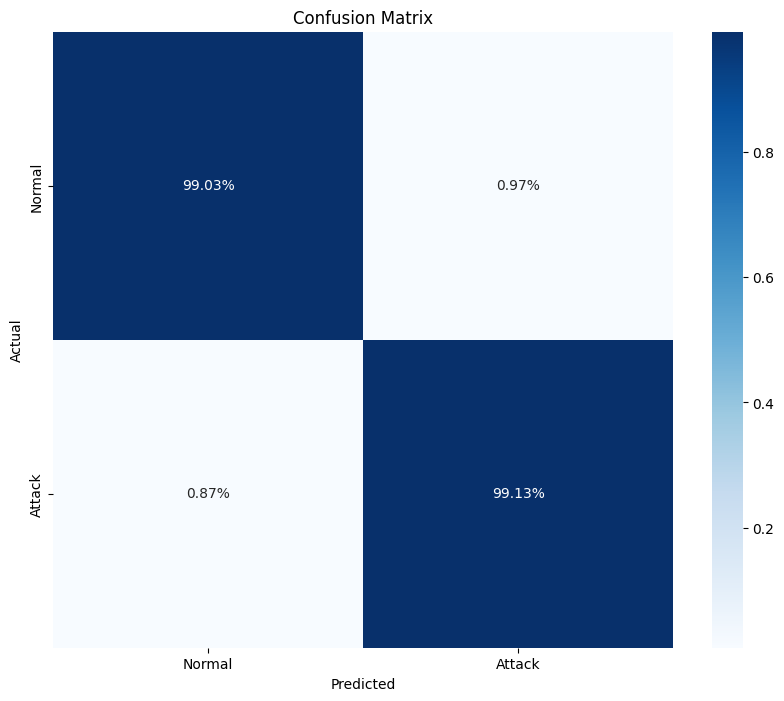

In [21]:
model.eval()
test_loader = DataLoader(testDataset, batch_size=batch_size, shuffle=False)

all_preds = []
all_labels = []

with torch.no_grad():
    for data_batch in test_loader:
        x_batch = data_batch["given"].to(device)
        y_batch = data_batch["label"].to(device)
        outputs = model(x_batch)
        y_batch_indices = torch.argmax(y_batch, dim=1)
        predicted = torch.argmax(outputs, dim=1)
        all_preds.extend(predicted.cpu().numpy())
        all_labels.extend(y_batch_indices.cpu().numpy())

all_preds = np.array(all_preds).reshape(-1)
all_labels = np.array(all_labels).reshape(-1)

accuracy = (all_preds == all_labels).mean()
precision = precision_score(all_labels, all_preds, average='macro', zero_division=0)
recall = recall_score(all_labels, all_preds, average='macro', zero_division=0)
f1 = f1_score(all_labels, all_preds, average='macro', zero_division=0)

print(f'Test Accuracy: {accuracy:.4f} | Precision: {precision:.4f} | Recall: {recall:.4f} | F1-score: {f1:.4f}\n')

cm = confusion_matrix(all_labels, all_preds)
plt.figure(figsize=(10, 8))
sns.heatmap(cm / cm.sum(axis=1)[:, np.newaxis], annot=True, fmt='.2%', cmap='Blues', xticklabels=['Normal', 'Attack'], yticklabels=['Normal', 'Attack'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

In [22]:
variables_map_idxs_array = []
for key, value in variables_map.items():
    variables_map_idxs_array.append(value)

In [23]:
import tsg_shap
from tsg_shap import StrategySubsets, StrategyGrouping, StrategyPrediction
from tsg_shap import generateSubsets

In [24]:
random_samples = random.sample(range(len(trainDataset)), 100)
support = [trainDataset[idx] for idx in random_samples]

begin = 798 #begining instant to be explained
end = begin + 100 #end instant to be explained
test = [testDataset[idx] for idx in range(begin, end)]


/home/manuelfrancop/Escritorio/TS-SHAP/gitAbril25/TSG-SHAP/tsg_shap/tsg_shap.py:350: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


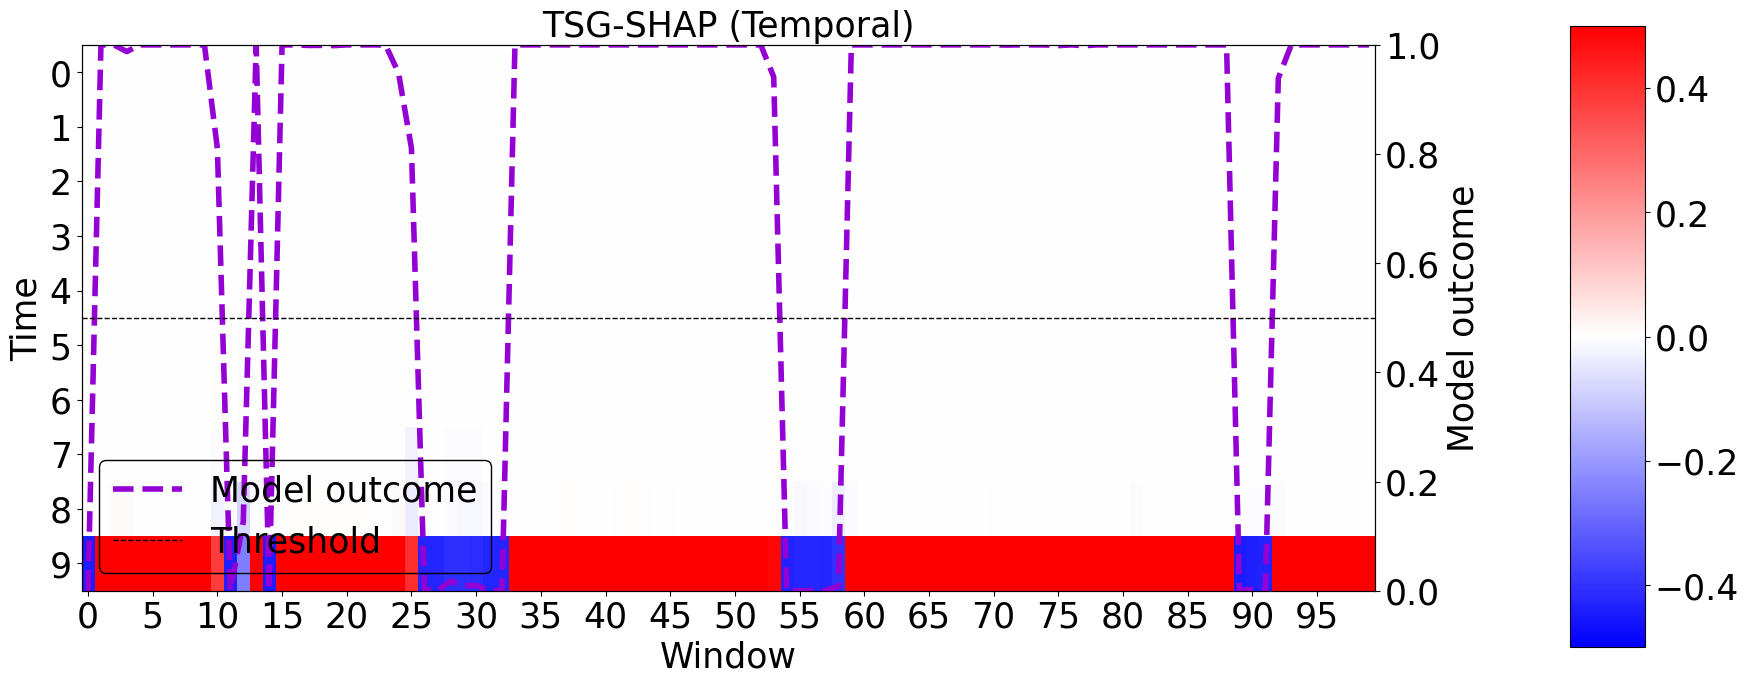

In [25]:
shapley_class = tsg_shap.ShaTS(model, 
                               support ,
                               classToExplain = 1,
                               strategyGrouping=StrategyGrouping.TIME,
                               nameInstants= [str(i) for i in range(10)])

#shapley_values = shapley_class.compute_tsgshap(test)
shapley_values = shapley_class.compute_fastShats(test)


shapley_class.plot_tsgshap(shapley_values, test)

/home/manuelfrancop/Escritorio/TS-SHAP/gitAbril25/TSG-SHAP/tsg_shap/tsg_shap.py:350: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


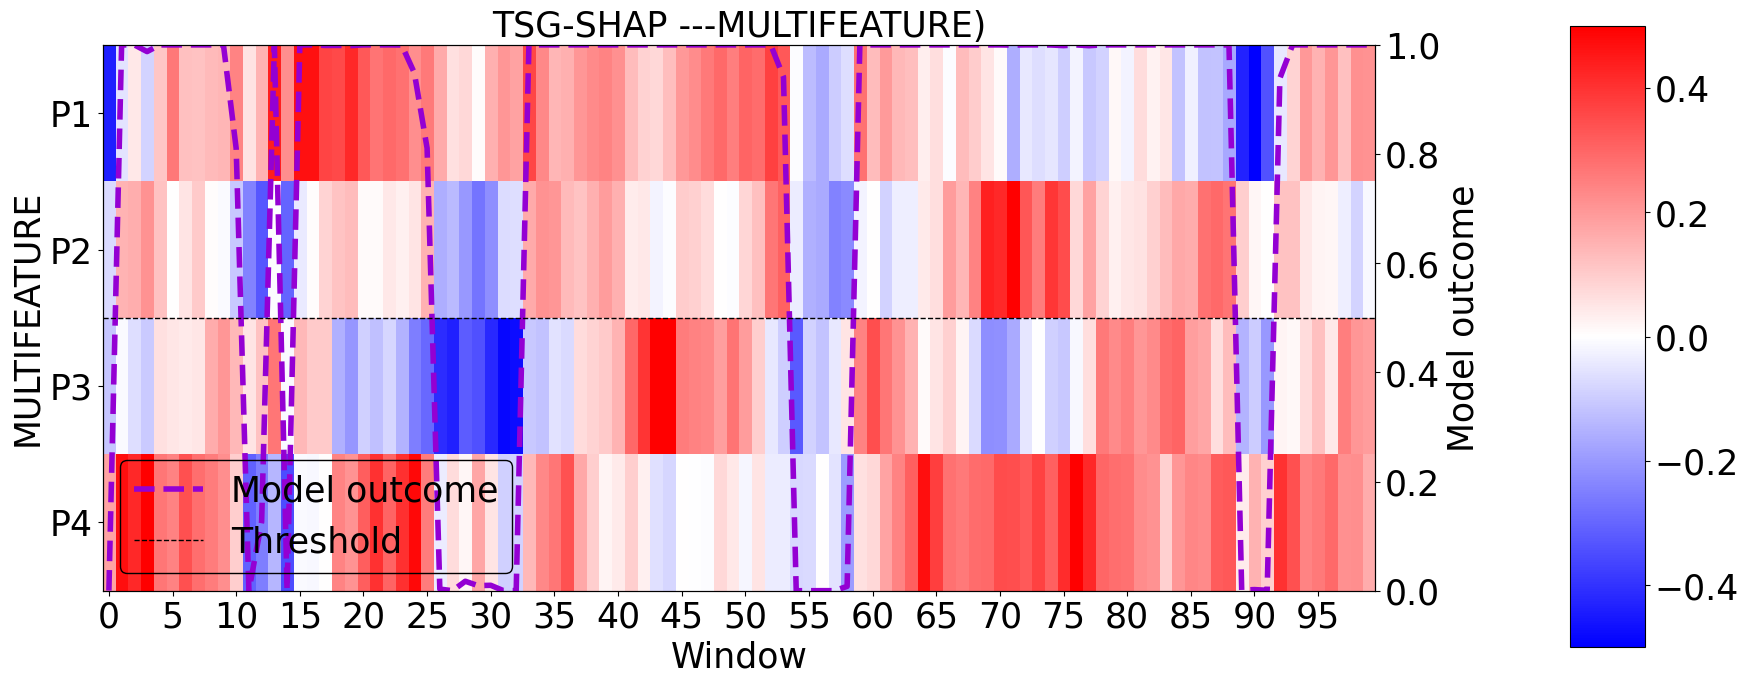

In [26]:
shapley_class = tsg_shap.ShaTS(model, 
                               support ,
                               classToExplain = 1,
                               strategyGrouping=StrategyGrouping.MULTIFEATURE,
                               customGroups=process,
                               nameGroups = ['P1', 'P2', 'P3', 'P4'])

shapley_values = shapley_class.compute_tsgshap(test)

shapley_class.plot_tsgshap(shapley_values, test)

/home/manuelfrancop/Escritorio/TS-SHAP/gitAbril25/TSG-SHAP/tsg_shap/utils.py:154: RuntimeWarning: divide by zero encountered in scalar divide
  m = (numSubsetsDesired - intercept) / slope
/home/manuelfrancop/Escritorio/TS-SHAP/gitAbril25/TSG-SHAP/tsg_shap/tsg_shap.py:350: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


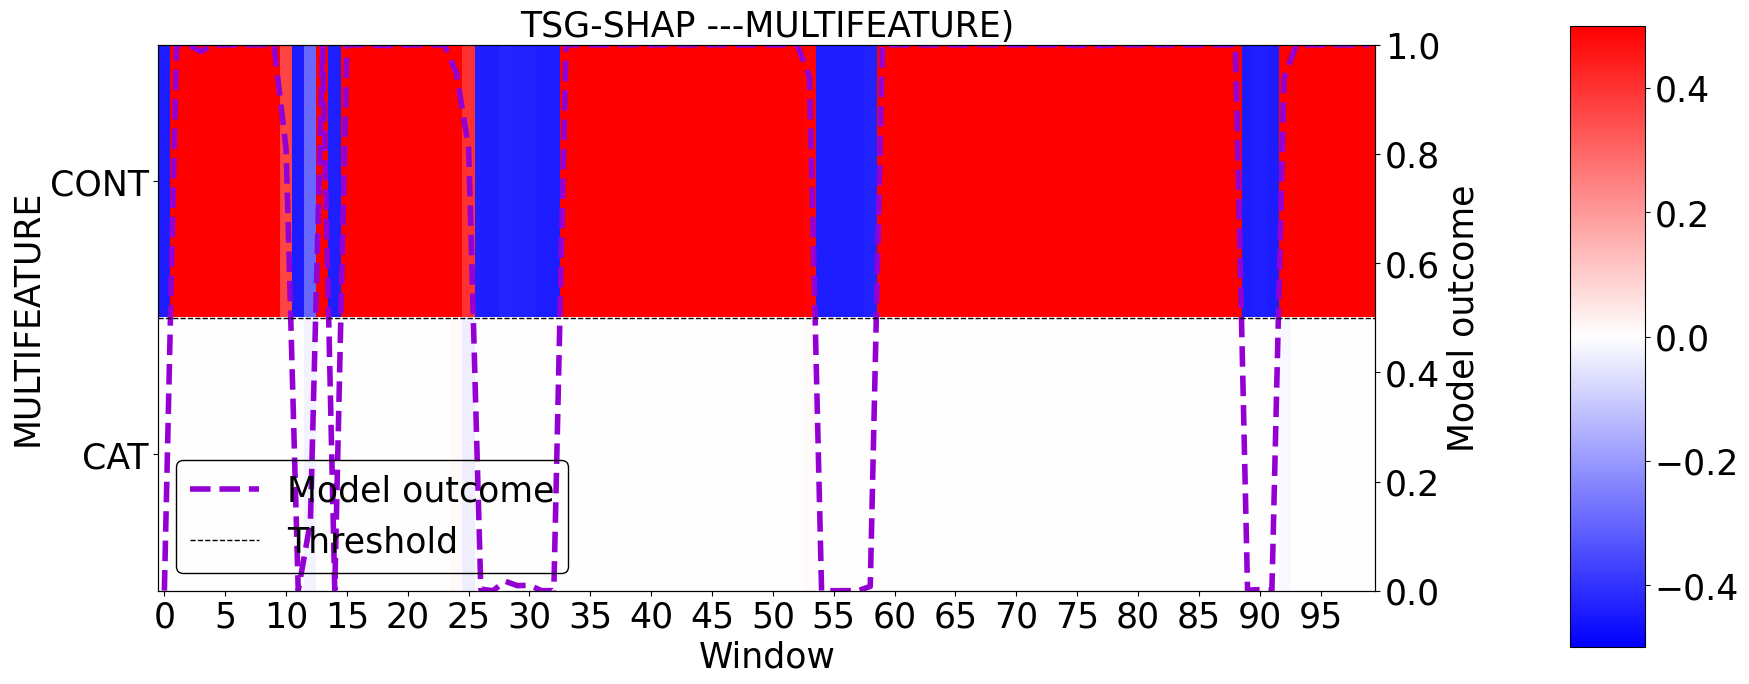

In [38]:
shapley_class = tsg_shap.ShaTS(model, 
                               support ,
                               classToExplain = 1,
                               strategyGrouping=StrategyGrouping.MULTIFEATURE,
                               customGroups=process2,
                               nameGroups = ['CONT', 'CAT'])

shapley_values = shapley_class.compute_tsgshap(test)
shapley_values = shapley_class.compute_fastShats(test)

shapley_class.plot_tsgshap(shapley_values, test)

/home/manuelfrancop/Escritorio/TS-SHAP/gitAbril25/TSG-SHAP/tsg_shap/tsg_shap.py:350: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


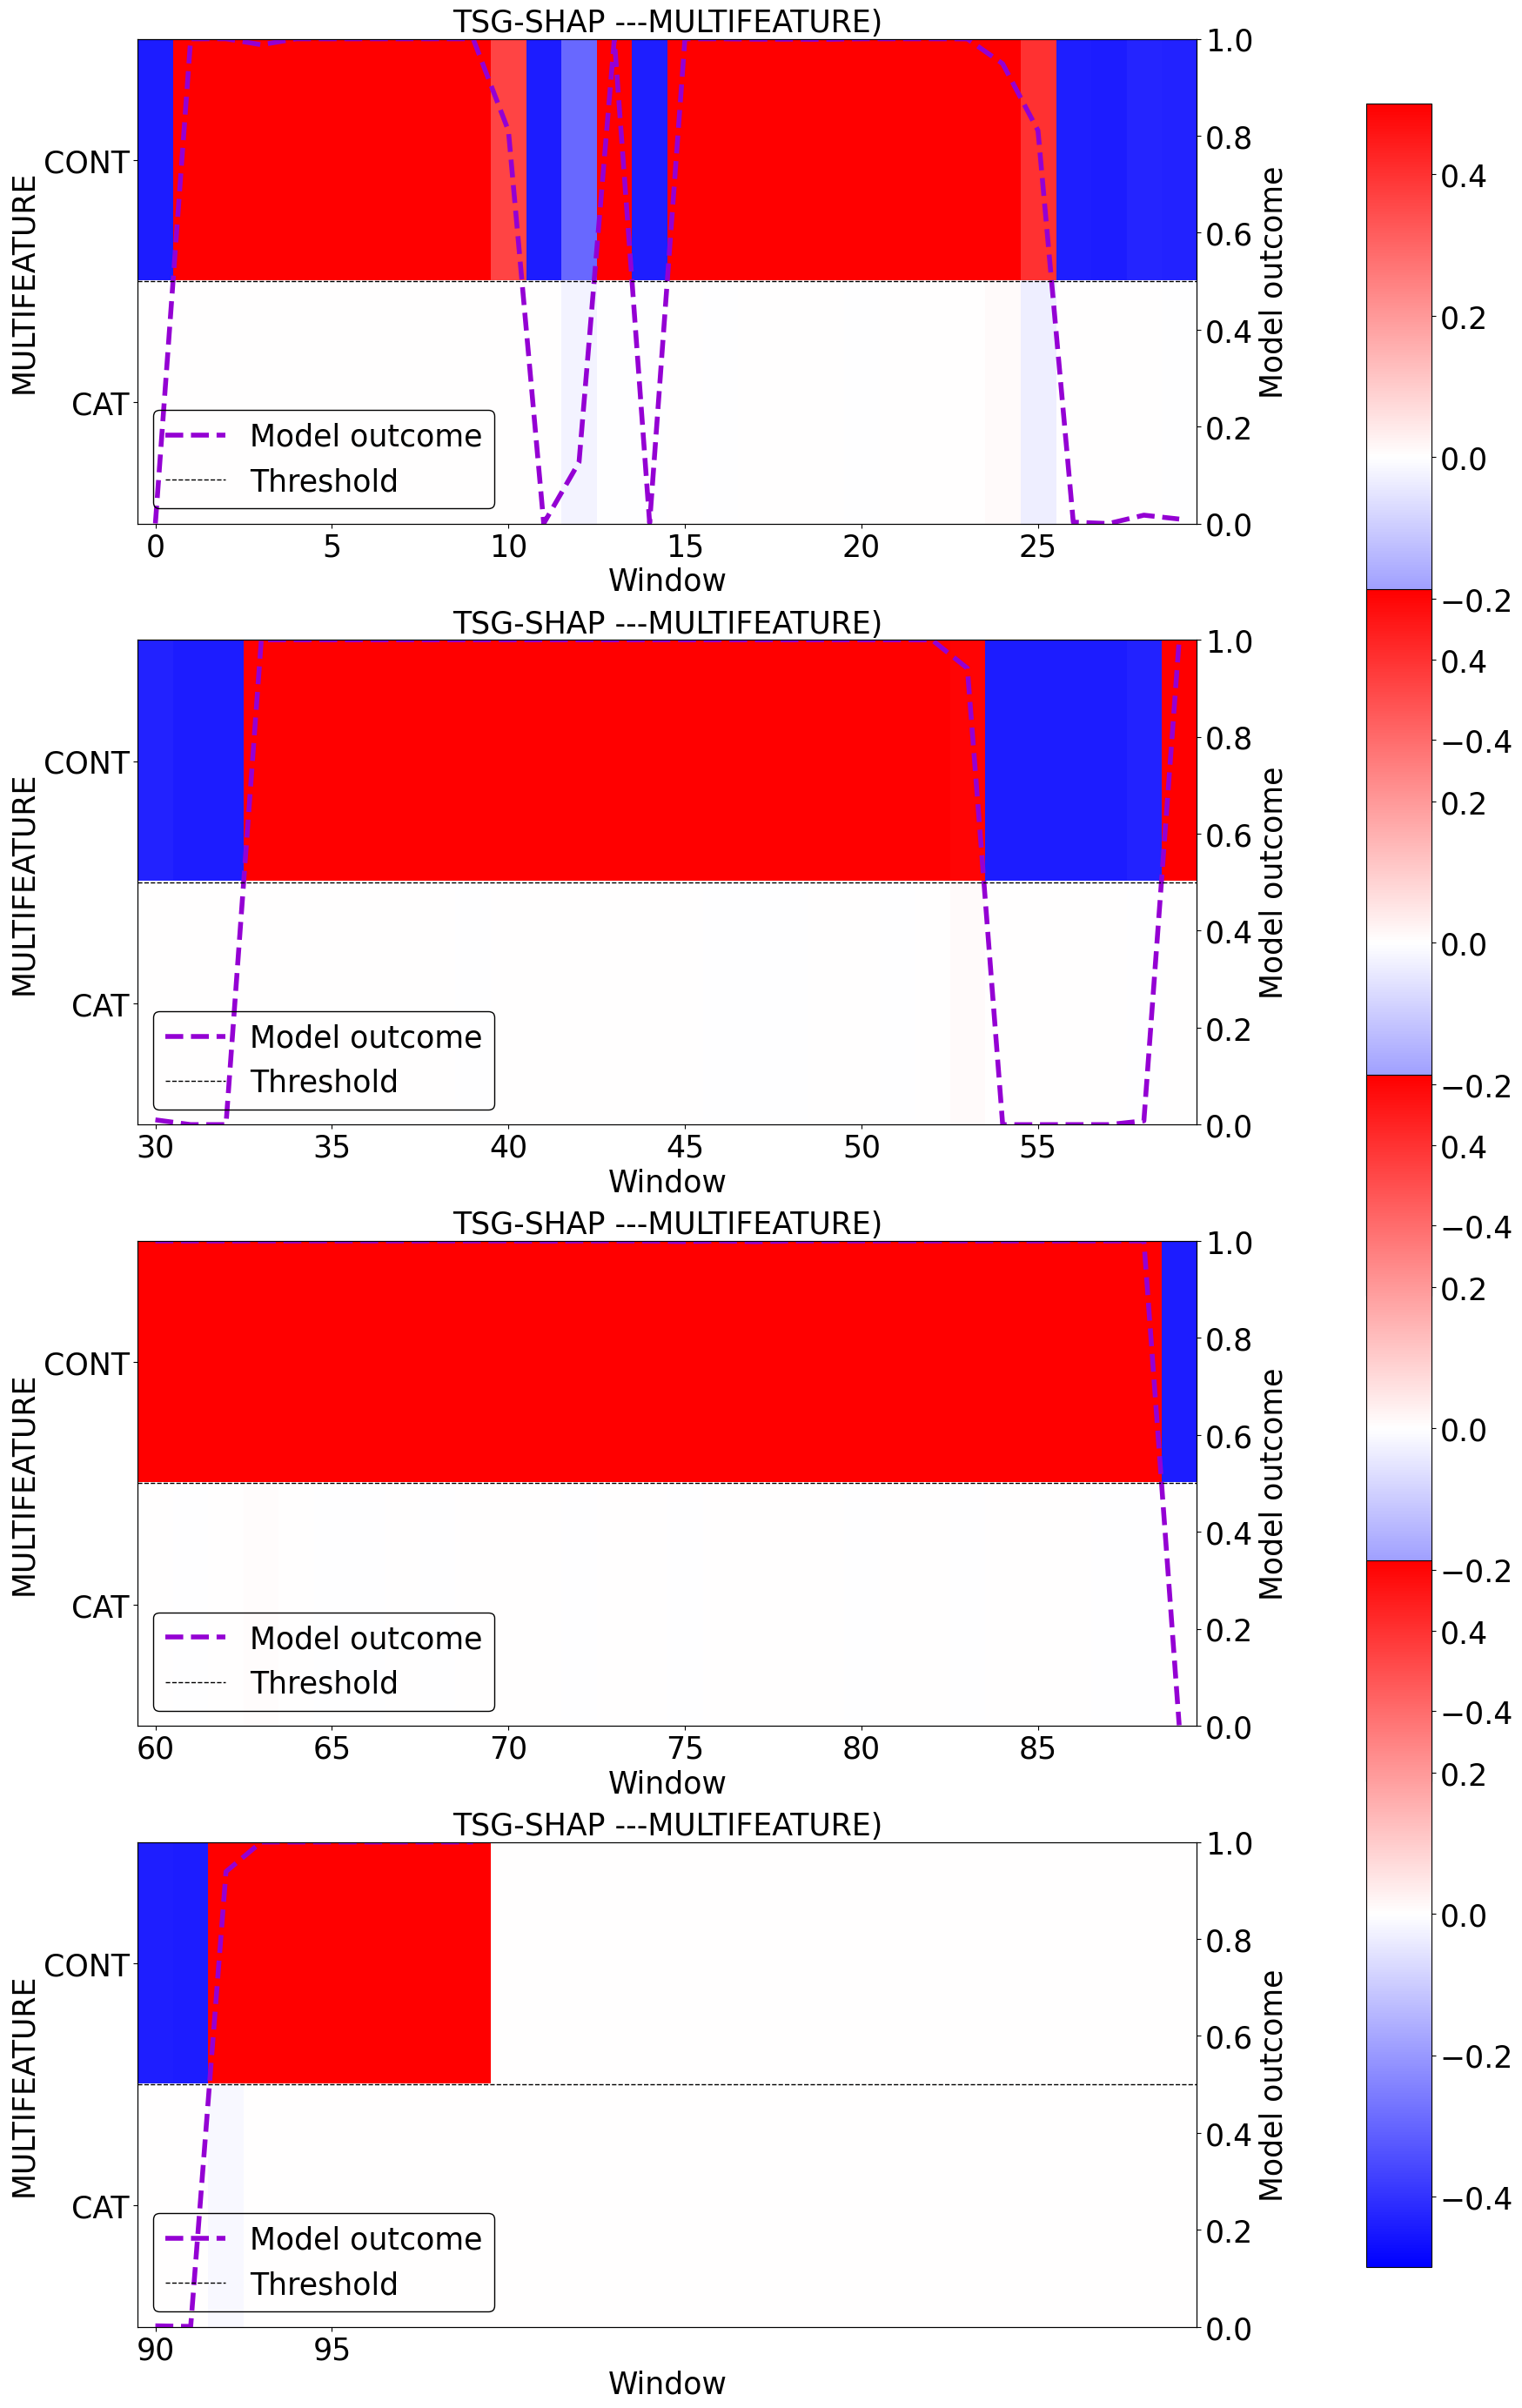

In [39]:
shapley_class.plot_tsgshap(shapley_values, test, segmentSize=30)

In [28]:
# Save Shapley values in a CSV file
shapley_values_cpu = shapley_values.cpu().numpy()  # Move to CPU and convert to NumPy
shapley_values_df = pd.DataFrame(shapley_values_cpu, columns = [str(i) for i in range(2)])
shapley_values_df.to_csv('experiments/exampleTemporalProcess2.csv', index=False)
print(shapley_values_df.head())

          0         1
0 -0.442926  0.000872
1  0.556754  0.000892
2  0.554933  0.002774
3  0.545035  0.000433
4  0.555382  0.002330


/home/manuelfrancop/Escritorio/TS-SHAP/gitAbril25/TSG-SHAP/tsg_shap/tsg_shap.py:350: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


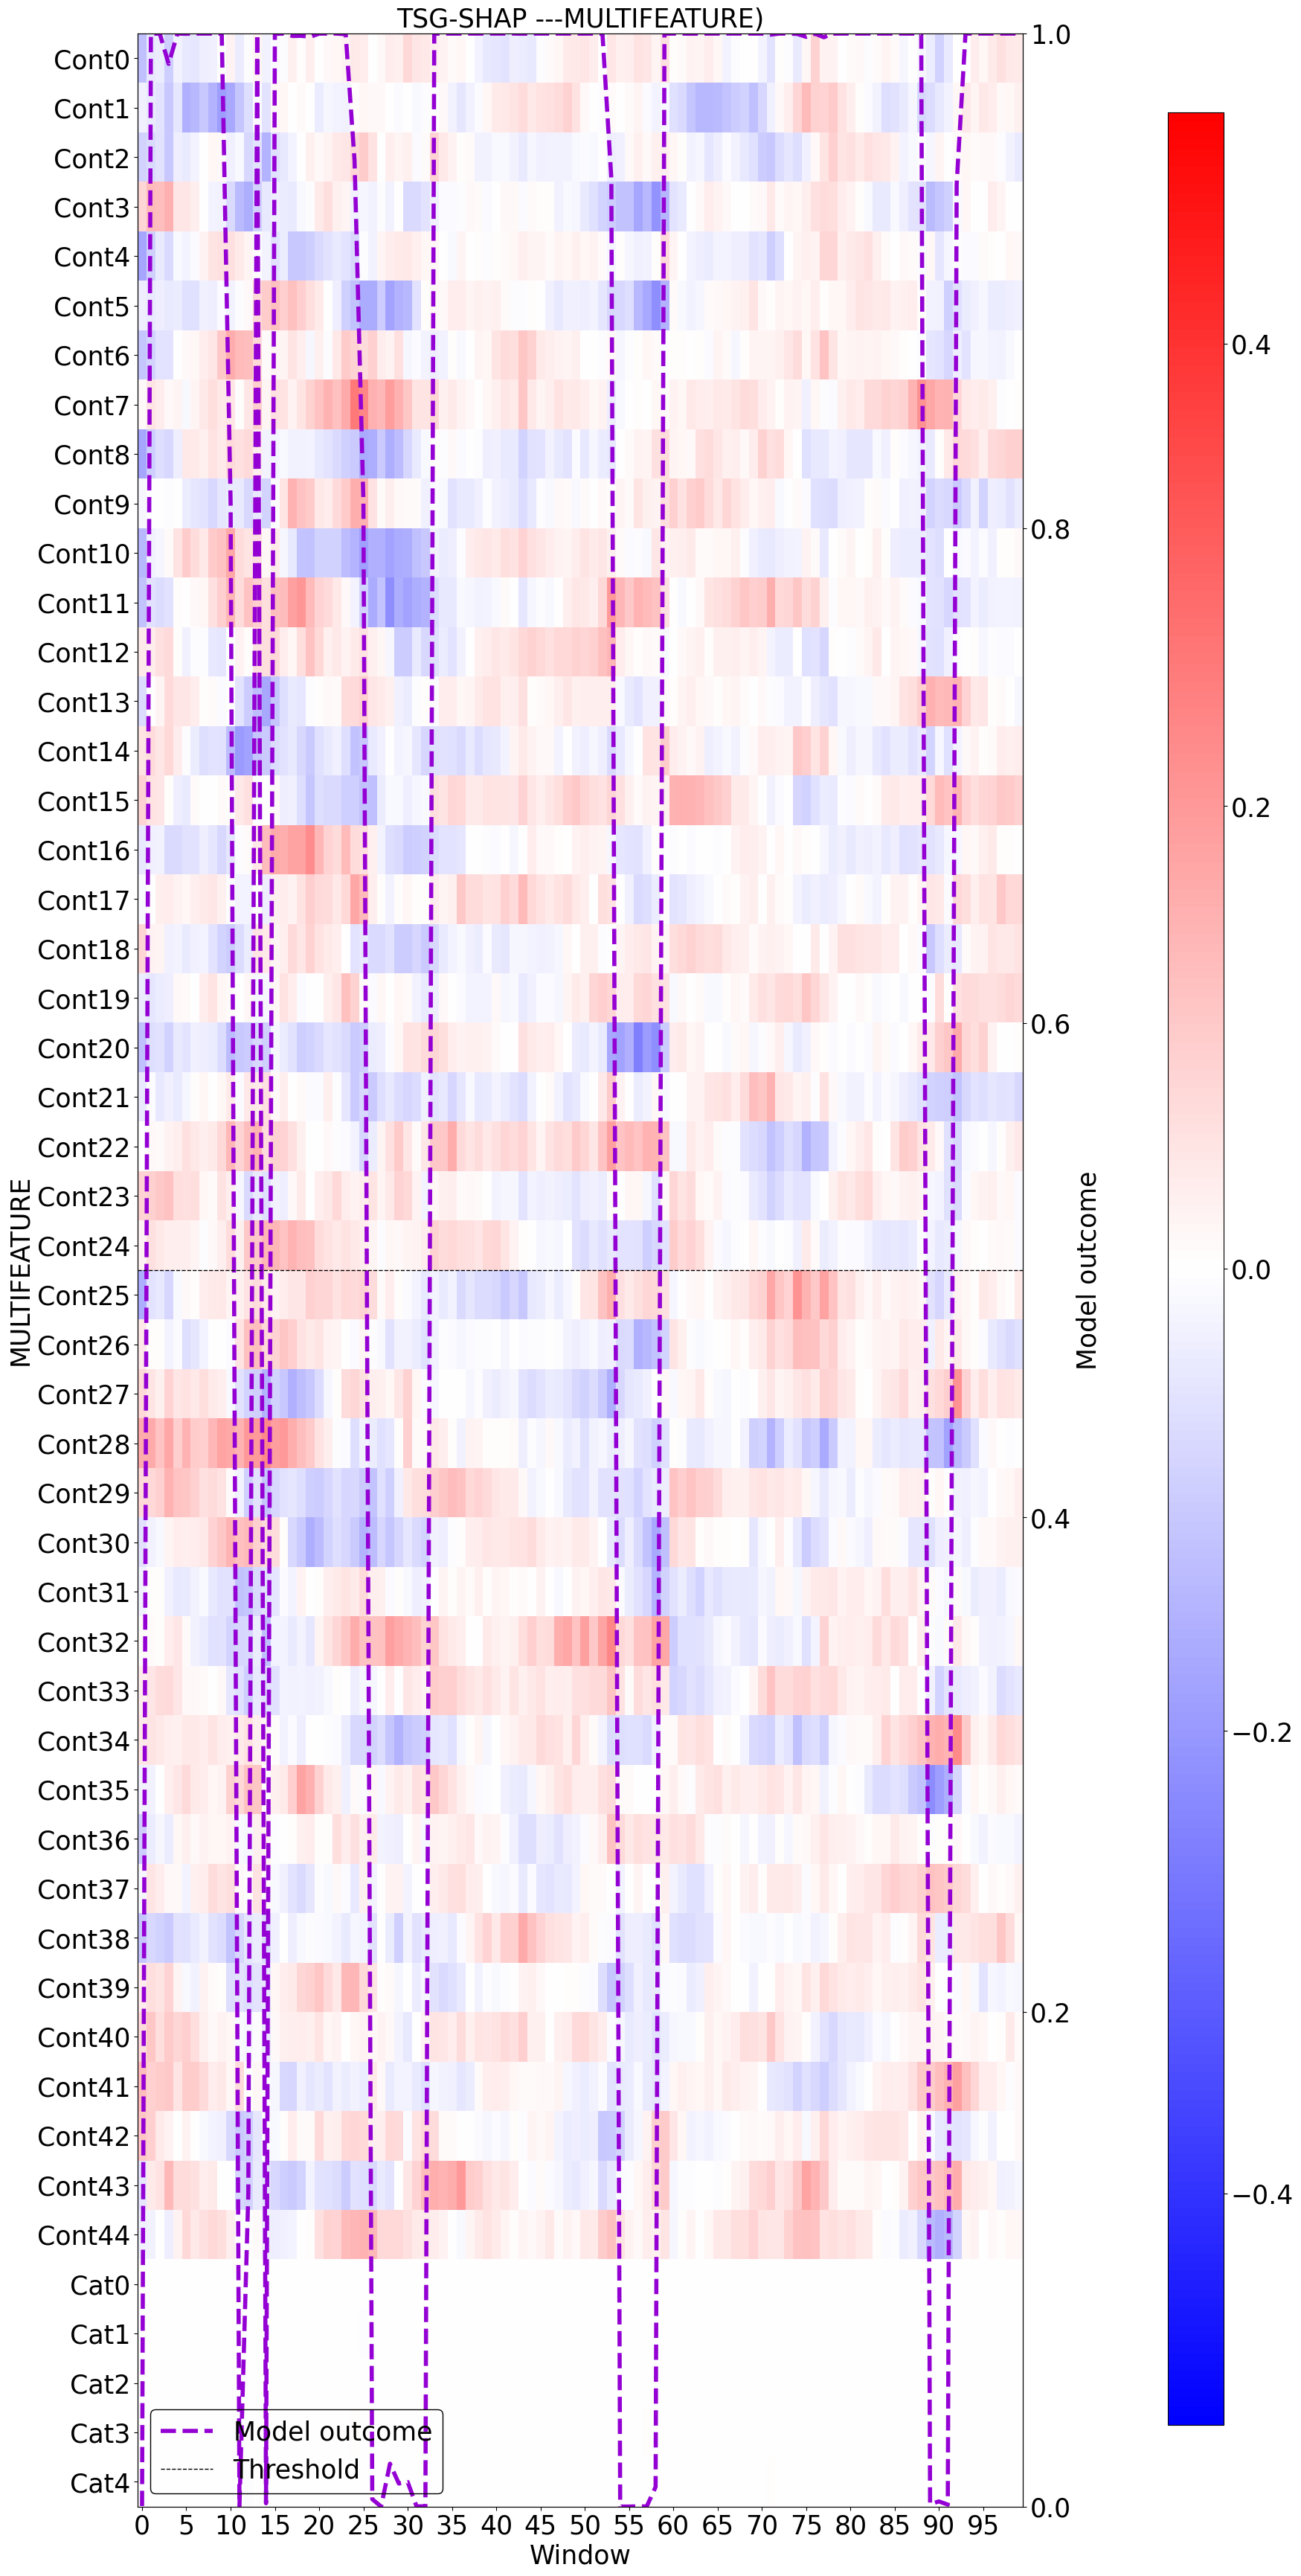

In [29]:
shapley_class = tsg_shap.ShaTS(model, 
                               support ,
                               classToExplain = 1,
                               strategyGrouping=StrategyGrouping.MULTIFEATURE,
                               customGroups=variables_map_idxs_array,
                               nameGroups = list(variables_map.keys()))

shapley_values = shapley_class.compute_fastShats(test)

shapley_class.plot_tsgshap(shapley_values, test)

In [30]:
# Save Shapley values in a CSV file
shapley_values_cpu = shapley_values.cpu().numpy()  # Move to CPU and convert to NumPy
shapley_values_df = pd.DataFrame(shapley_values_cpu, columns = [str(i) for i in range(len(variables_map_idxs_array))])
shapley_values_df.to_csv('experiments/FastexampleTemporalFeature.csv', index=False)
print(shapley_values_df.head())

          0         1         2         3         4         5         6  \
0 -0.122690 -0.028338 -0.088529  0.080776 -0.172772 -0.033055 -0.112952   
1 -0.045958 -0.041196 -0.072201  0.134426 -0.093102 -0.041718 -0.084055   
2 -0.038521 -0.051652 -0.055362  0.125305 -0.042059 -0.033476 -0.054126   
3 -0.094391 -0.108678 -0.107781  0.154366 -0.073787 -0.039844 -0.054614   
4 -0.025637 -0.048397 -0.031761  0.050362 -0.012533 -0.036234  0.001104   

          7         8         9  ...        40        41        42        43  \
0  0.013078 -0.172020 -0.017960  ...  0.070126  0.132287  0.112883 -0.049968   
1  0.051172 -0.097609 -0.000973  ...  0.112704  0.092154  0.096616  0.040798   
2  0.038754 -0.063378  0.000956  ...  0.066373  0.098293  0.041797  0.054907   
3  0.014465 -0.076475 -0.006254  ...  0.104319  0.108084  0.024240  0.137069   
4  0.019917 -0.031490 -0.002889  ...  0.078394  0.054008  0.003505  0.067200   

         44        45        46        47        48        49  
0 -0

In [31]:
# import FastexampleTemporalFeature.csv and exampleTemporalFeature.csv and compare the results
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import seaborn as sns


# Load the CSV files
df1 = pd.read_csv('experiments/FastexampleTemporalFeature.csv')
df2 = pd.read_csv('experiments/exampleTemporalFeature.csv')

#print(df1.head())
#print(df2.head())

print(df1 - df2)

           0         1         2         3         4         5         6  \
0  -0.024801  0.010852 -0.007382  0.009505 -0.032843 -0.010247 -0.000676   
1  -0.006671  0.001878  0.002784  0.037095 -0.028002 -0.007270 -0.009222   
2  -0.006993 -0.004113 -0.002449  0.030194 -0.011332 -0.001239  0.001522   
3  -0.014680  0.006687 -0.002933  0.025304 -0.032673 -0.005448  0.000927   
4  -0.007775 -0.004243 -0.006590  0.013154 -0.010818 -0.004742  0.003610   
..       ...       ...       ...       ...       ...       ...       ...   
95  0.000071  0.019185 -0.004994  0.007256 -0.011865 -0.010432  0.007373   
96 -0.002758  0.013627 -0.005711  0.006119 -0.010163 -0.007552  0.008131   
97  0.001086  0.009889 -0.003913  0.002916 -0.009528 -0.009584  0.009810   
98 -0.003548  0.010538 -0.000046  0.000475 -0.007837 -0.005938  0.010064   
99  0.000774  0.012457  0.001565  0.003167 -0.008539 -0.004309  0.012668   

           7         8         9  ...        40        41        42        43  \
0   0.